In [3]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import Counter

api = wandb.Api()

In [4]:
runs = api.runs("qba/rehersal Alexnet MNIST Task IL tr-t split v2")

In [5]:
runs_list = []

for run in runs:
    runs_list.append(run.config)

df = pd.DataFrame(runs_list).astype(str)

df

setup epochs  dataset                                       project  \
0     taskIL      5  CIFAR10  rehersal Alexnet MNIST Task IL tr-t split v2   
1     taskIL      5  CIFAR10  rehersal Alexnet MNIST Task IL tr-t split v2   
2     taskIL      5  CIFAR10  rehersal Alexnet MNIST Task IL tr-t split v2   
3     taskIL      5  CIFAR10  rehersal Alexnet MNIST Task IL tr-t split v2   
4     taskIL      5  CIFAR10  rehersal Alexnet MNIST Task IL tr-t split v2   
..       ...    ...      ...                                           ...   
115  task IL      5  CIFAR10                                           nan   
116  task IL      5  CIFAR10                                           nan   
117  task IL      5  CIFAR10                                           nan   
118  task IL      5  CIFAR10                                           nan   
119  task IL      5  CIFAR10                                           nan   

    batch_size pretraining         architecture  \
0        128.0       False         SmallAlexNet   
1        128.0       False         SmallAlexNet   
2        128.0       False         SmallAlexNet   
3        128.0       False         SmallAlexNet   
4        128.0       False         SmallAlexNet   
..         ...         ...                  ...   
115        nan         nan  SmallAlexNetTasklIL   
116        nan         nan  SmallAlexNetTasklIL   
117        nan         nan  SmallAlexNetTasklIL   
118        nan         nan  SmallAlexNetTasklIL   
119        nan         nan  SmallAlexNetTasklIL   

                                 classes_list learning_rate  \
0    [[0, 8], [5, 4], [6, 9], [1, 3], [7, 2]]         0.001   
1    [[9, 8], [0, 2], [5, 4], [3, 1], [6, 7]]         0.001   
2    [[8, 5], [9, 3], [7, 4], [6, 1], [2, 0]]         0.001   
3    [[9, 1], [0, 8], [7, 5], [2, 4], [3, 6]]         0.001   
4    [[2, 7], [4, 3], [6, 5], [1, 8], [0, 9]]        0.0001   
..                                        ...           ...   
115                                       nan          0.01   
116                                       nan          0.01   
117                                       nan          0.01   
118                                       nan          0.01   
119                                       nan          0.01   

           rehearsal_dataset batch_size_rehearsal  
0    stat-spectrum_color_wmm                128.0  
1    stat-spectrum_color_wmm                128.0  
2    stat-spectrum_color_wmm                128.0  
3    stat-spectrum_color_wmm                128.0  
4                       None                128.0  
..                       ...                  ...  
115        dead_leaves-mixed                  nan  
116        dead_leaves-mixed                  nan  
117        dead_leaves-mixed                  nan  
118        dead_leaves-mixed                  nan  
119      dead_leaves-squares                  nan  

[120 rows x 11 columns]

In [6]:
UID = ['rehearsal_dataset', 'batch_size_rehearsal', 'pretraining', 'learning_rate']
df['UID'] = ''

for c in UID:
    df['UID'] += df[c].astype(str)+';'

In [7]:
unique_UID = df['UID'].unique()
unique_run_params = []

for uuid in unique_UID:
    unique_run_params.append(uuid.split(';')[:4])
unique_run_params

[['stat-spectrum_color_wmm', '128.0', 'False', '0.001'],
 ['None', '128.0', 'False', '0.0001'],
 ['None', '128.0', 'False', '3e-05'],
 ['None', '128.0', 'False', '1e-05'],
 ['stat-wmm', '128.0', 'False', '0.001'],
 ['stat-spectrum_color_wmm', '128.0', 'True', '0.001'],
 ['stat-wmm', '128.0', 'True', '0.001'],
 ['None', '128.0', 'False', '0.001'],
 ['stat-wmm', '256.0', 'True', '0.01'],
 ['stat-wmm', '128.0', 'True', '0.01'],
 ['stat-wmm', '64.0', 'nan', '0.01'],
 ['stat-wmm', '16.0', 'nan', '0.01'],
 ['stat-wmm', '32.0', 'nan', '0.01'],
 ['', 'nan', 'nan', '0.01'],
 ['stylegan-random', 'nan', 'nan', '0.01'],
 ['stylegan-highfreq', 'nan', 'nan', '0.01'],
 ['stat-wmm', 'nan', 'nan', '0.01'],
 ['stat-spectrum_color_wmm', 'nan', 'nan', '0.01'],
 ['stat-spectrum_color', 'nan', 'nan', '0.01'],
 ['stat-spectrum', 'nan', 'nan', '0.01'],
 ['dead_leaves-textures', 'nan', 'nan', '0.01'],
 ['dead_leaves-squares', 'nan', 'nan', '0.01'],
 ['dead_leaves-oriented', 'nan', 'nan', '0.01'],
 ['dead_leave

In [8]:
unique_run_settings_idxs = []

for run_param in unique_run_params:
    idx = pd.Series([True for _ in range(len(df))])
    for c, v in zip(UID, run_param):
        idx = (idx) & (df[c] == v)
    unique_run_settings_idxs.append(df[idx].index)

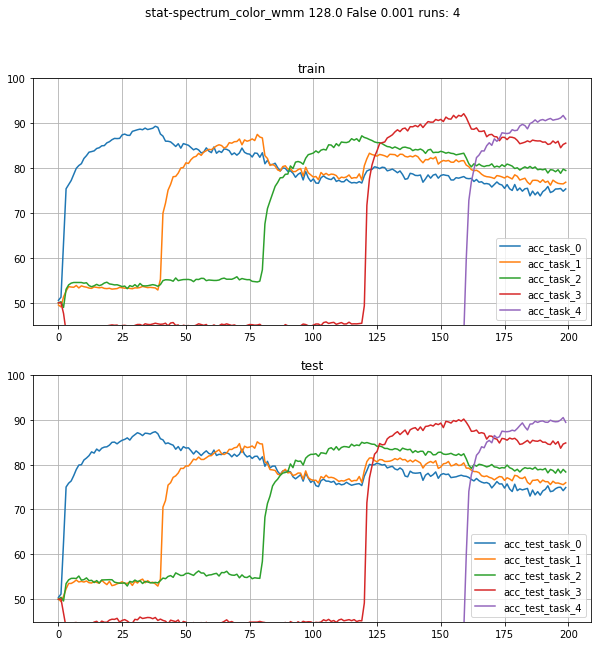

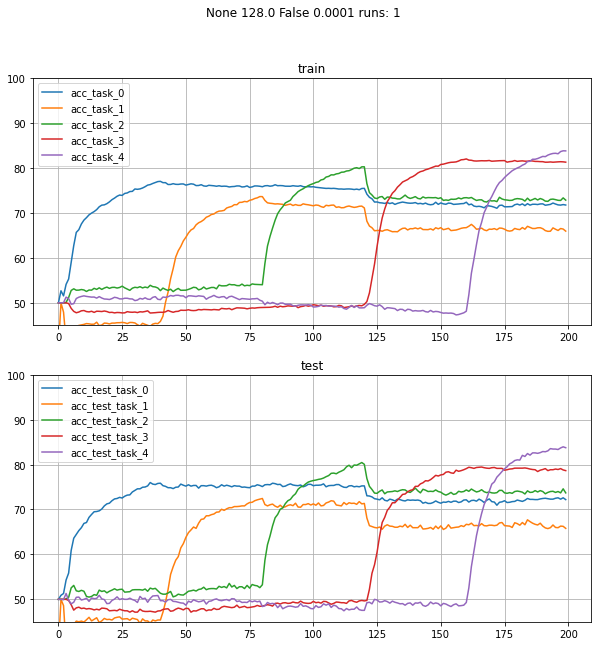

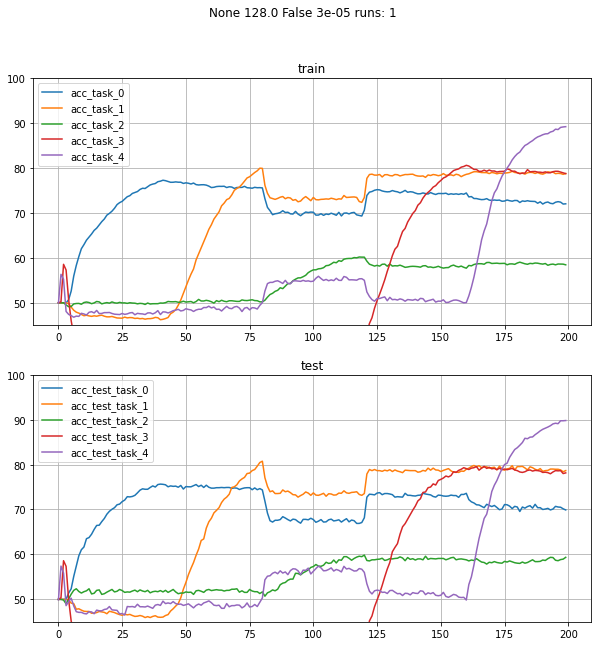

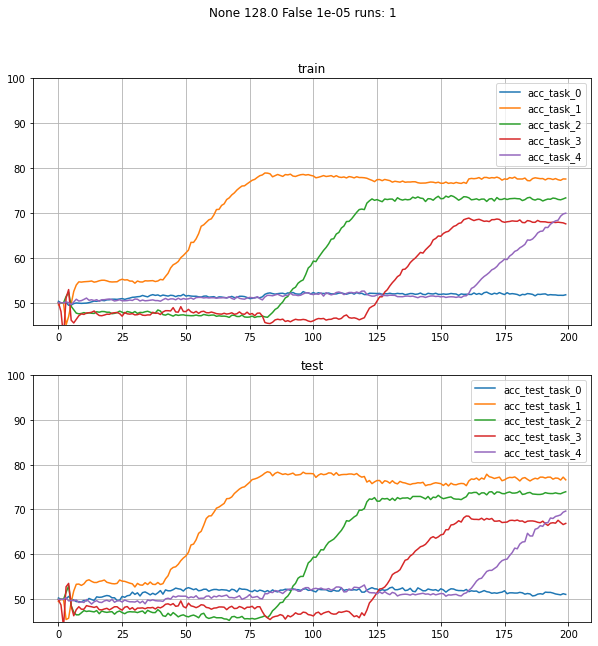

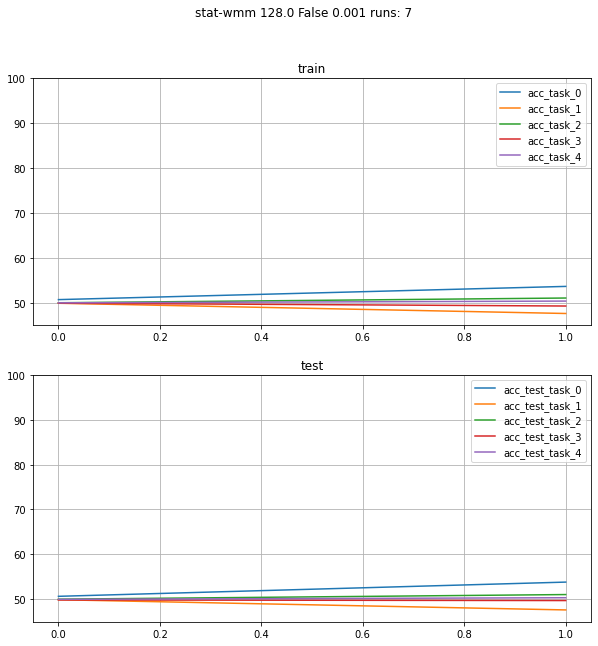

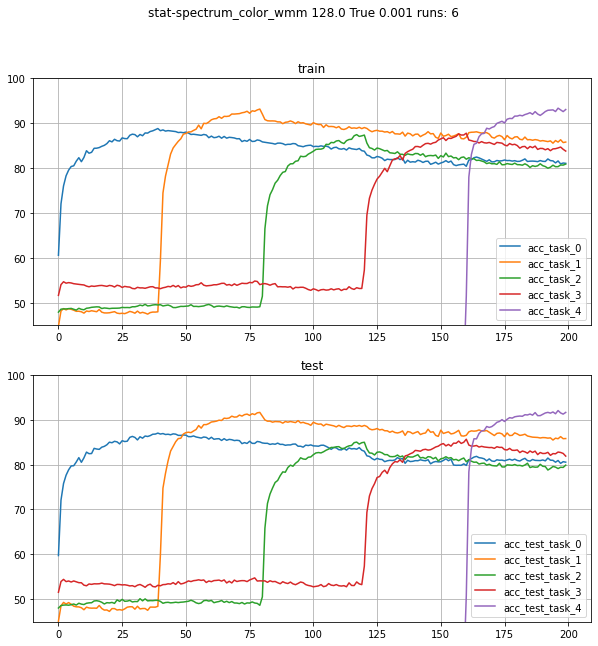

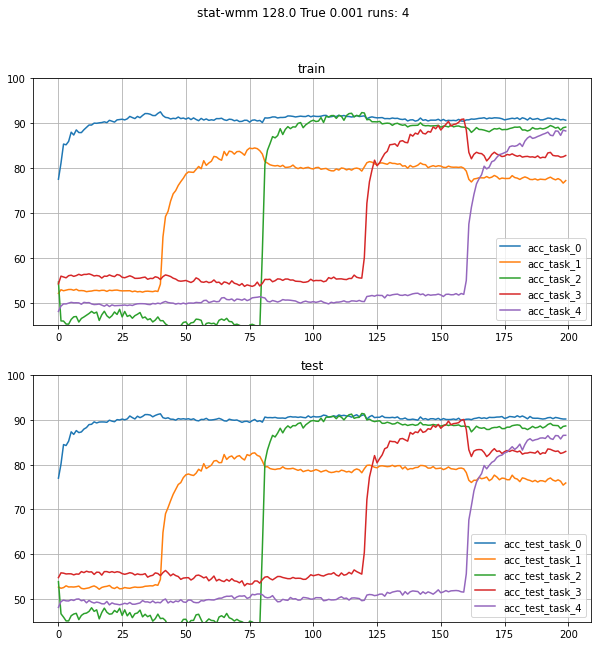

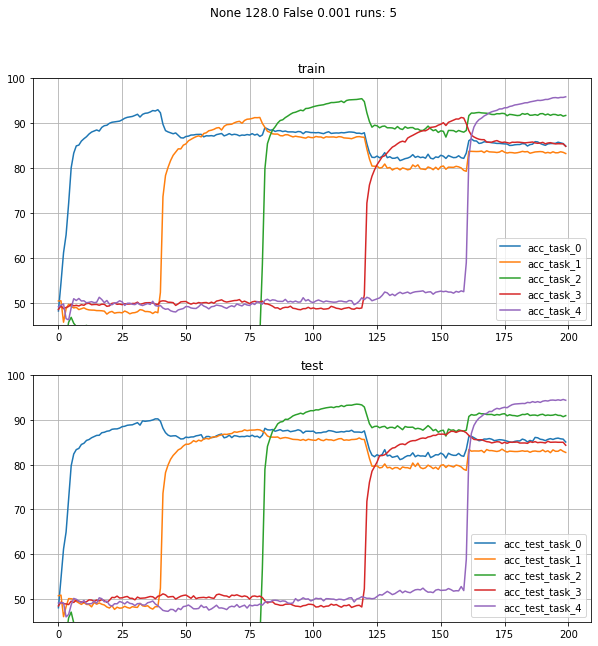

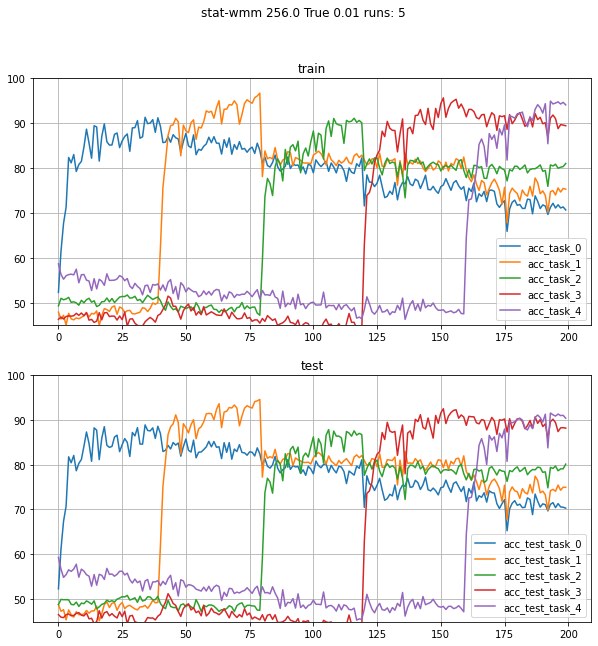

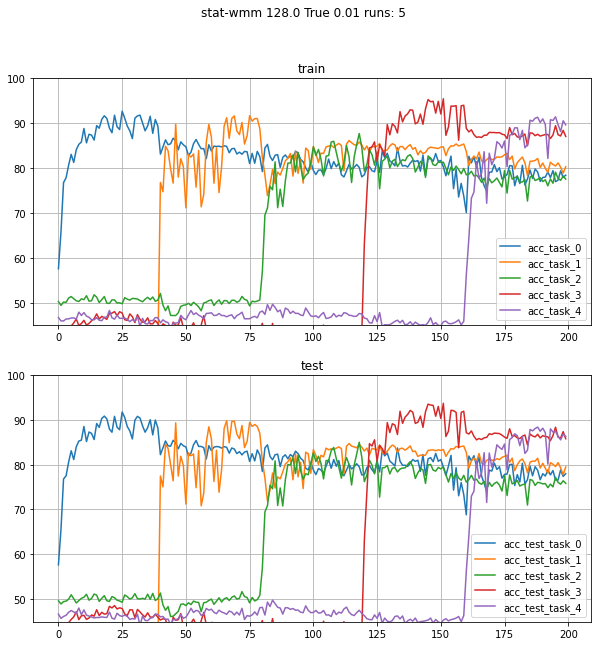

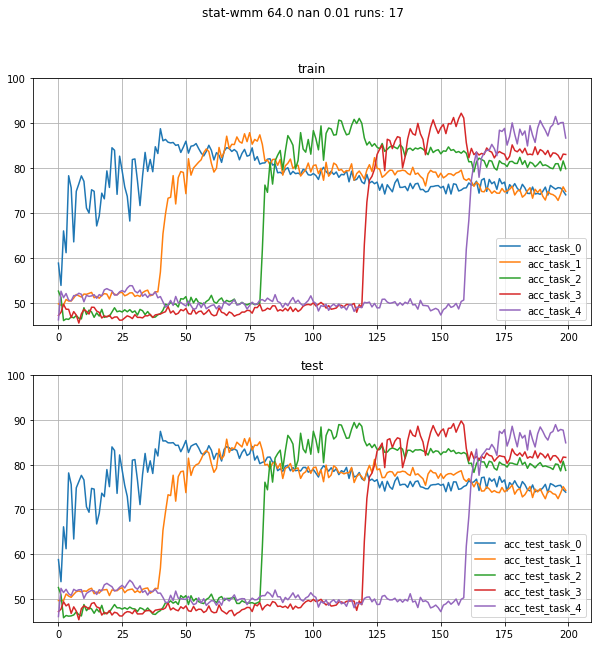

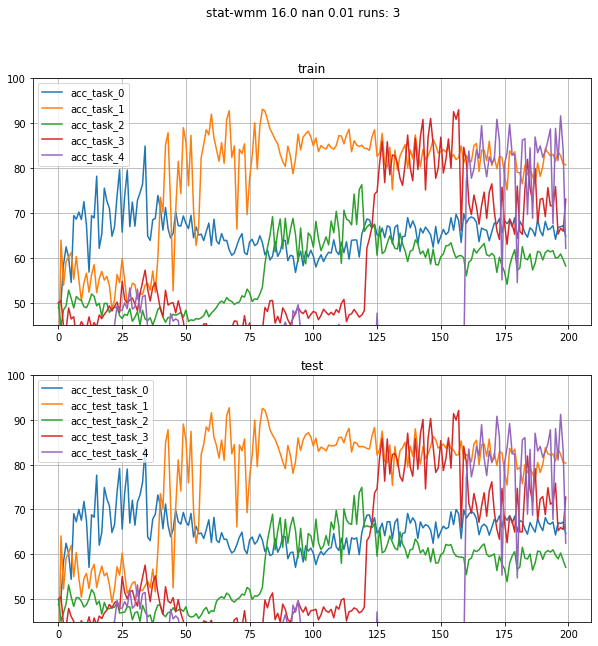

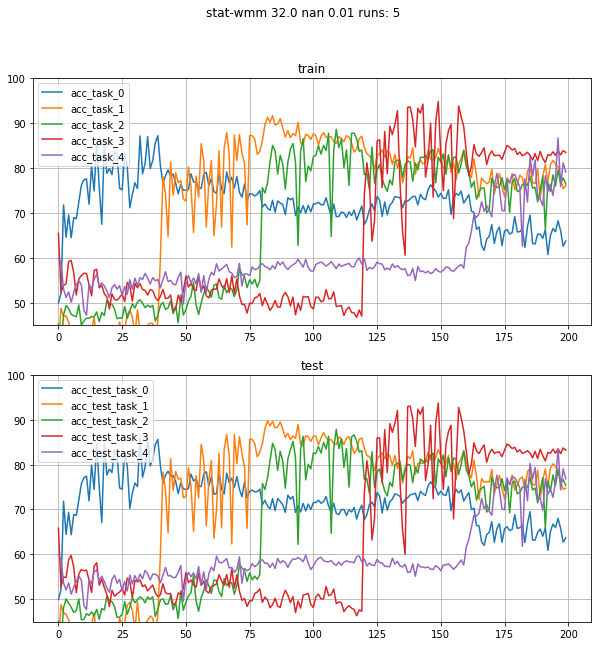

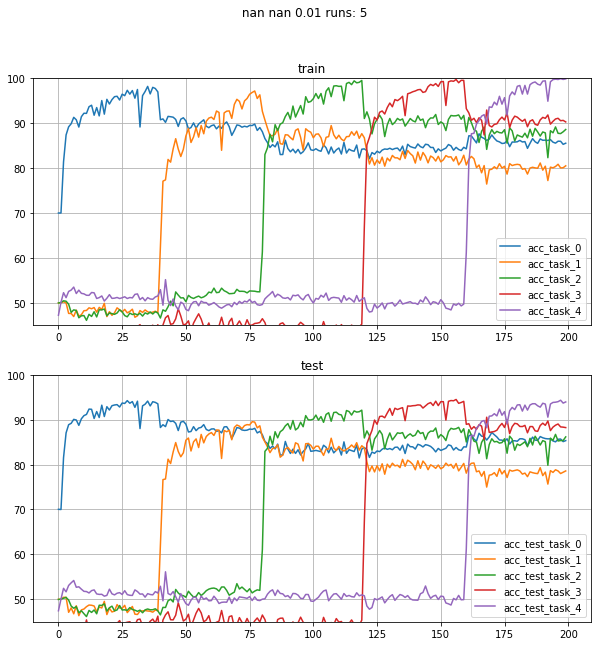

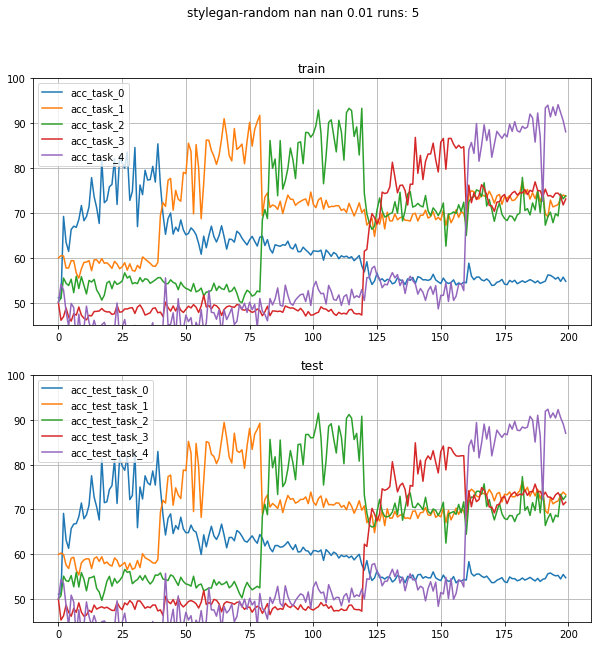

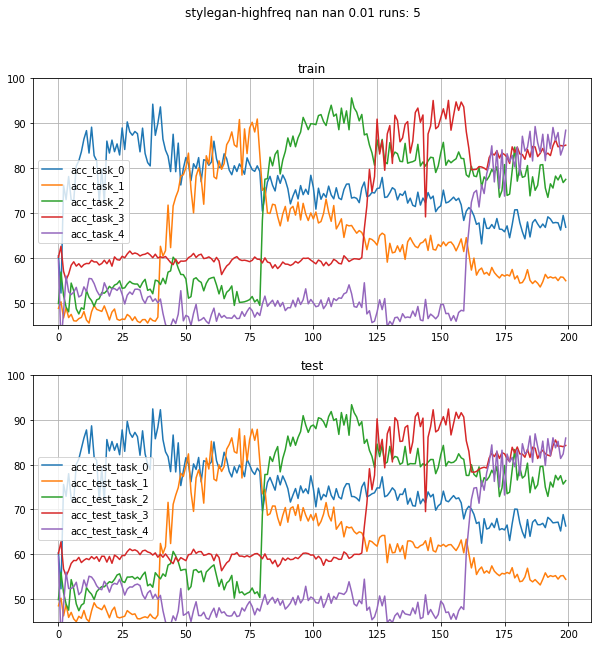

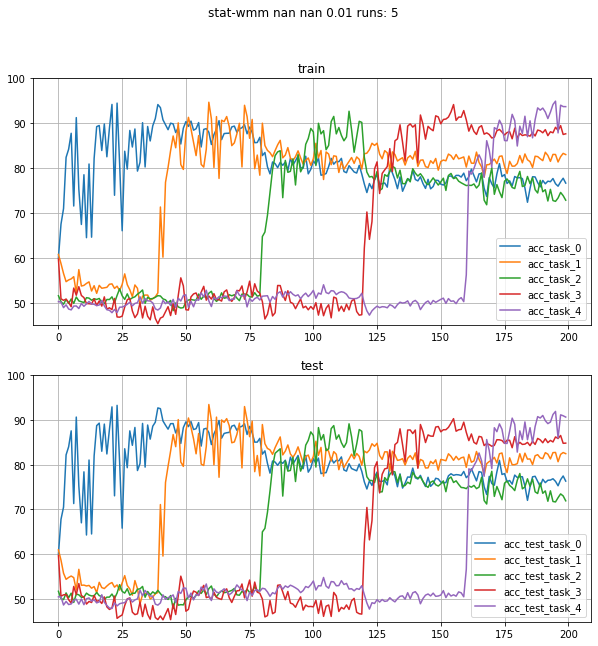

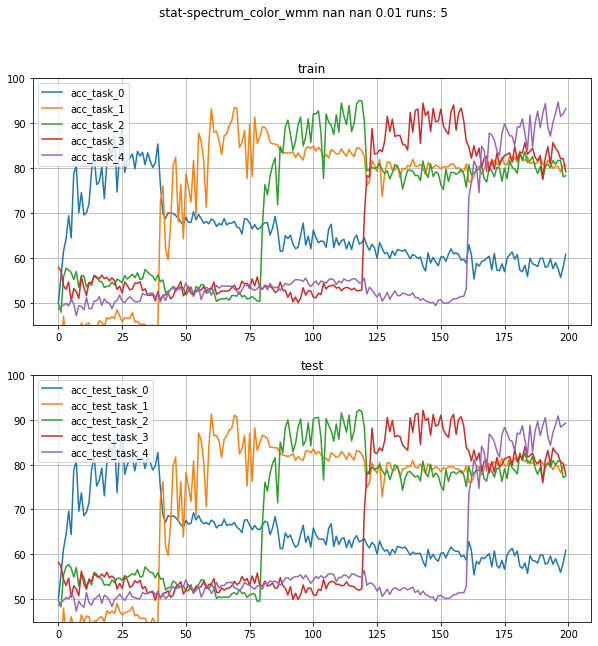

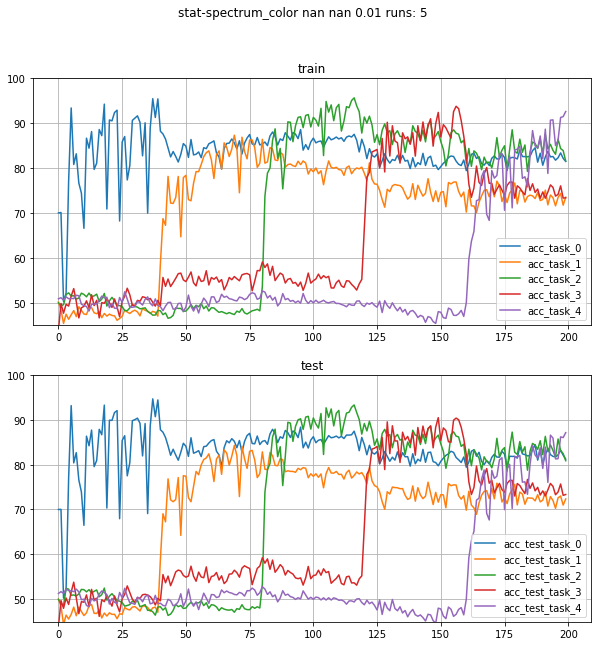

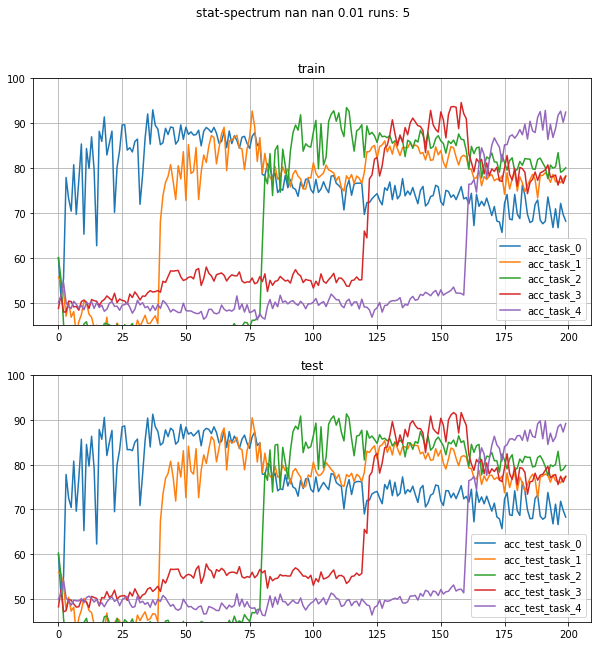

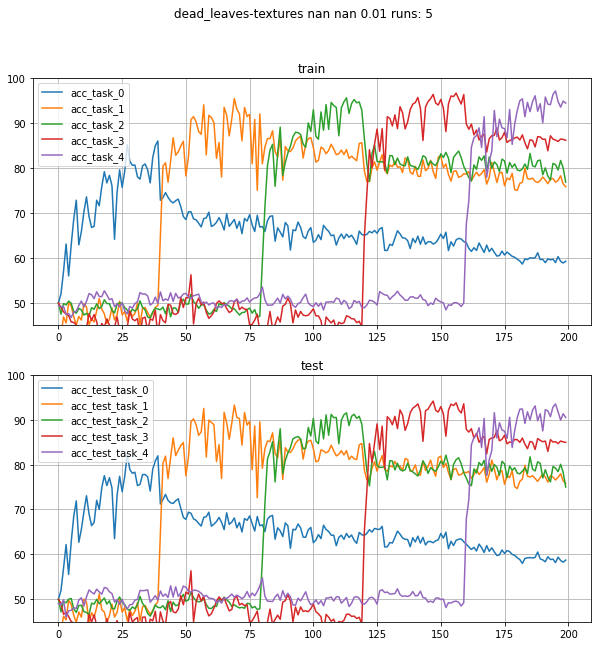

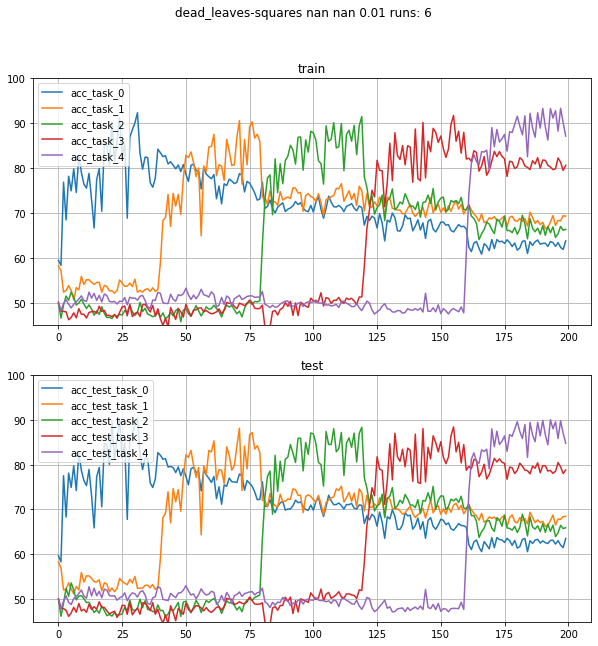

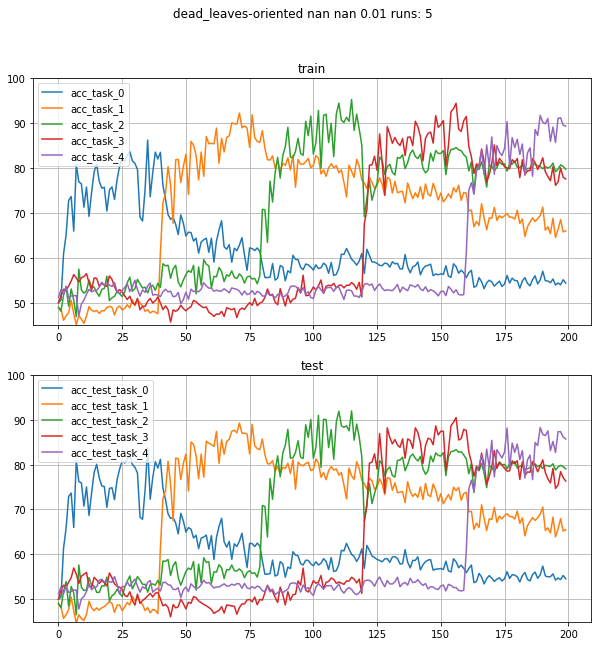

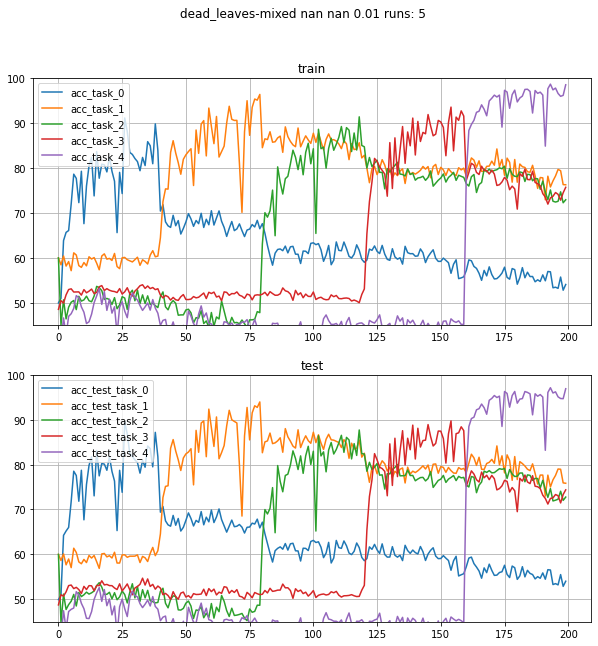

In [9]:
acc_col = ['acc_task_0', 'acc_task_1', 'acc_task_2', 'acc_task_3', 'acc_task_4']
acc_test_col = ['acc_test_task_0', 'acc_test_task_1', 'acc_test_task_2', 'acc_test_task_3', 'acc_test_task_4']

for unixe_idxs in unique_run_settings_idxs:
    df_train, df_test = pd.DataFrame(), pd.DataFrame()
    for run_idx in unixe_idxs.values:
        try:
            curr_run = runs[run_idx].history(100000)
            if len(df_train > 0):
                df_train += curr_run[acc_col].dropna().reset_index().drop(columns='index')
                df_test += curr_run[acc_test_col].dropna().reset_index().drop(columns='index')
            else:
                df_train = curr_run[acc_col].dropna().reset_index().drop(columns='index')
                df_test = curr_run[acc_test_col].dropna().reset_index().drop(columns='index')
        except Exception as e:
            print(f"Error in run: {run_idx} Error: {e}")
    try:
        df_train /= len(unixe_idxs)
        df_test /= len(unixe_idxs)

        fig, ax = plt.subplots(2,1)
        fig.set_figheight(10)
        fig.set_figwidth(10)
        fig.suptitle(df.iloc[unixe_idxs]['UID'].iloc[0].replace(';',' ') + f"runs: {len(unixe_idxs)}", fontsize=12)
        df_train.plot(ax=ax[0], grid=True, ylim=[45, 100], title='train')
        df_test.plot(ax=ax[1], grid=True, ylim=[45, 100], title='test')
        plt.show()
    except Exception as e:
        print(f"Exception with ids: {unixe_idxs}, exception: {e}")